In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import yfinance as yf 
from scipy import stats
from scipy.stats import t

import phik
from phik.report import plot_correlation_matrix
from phik import report

from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

from sklearn.model_selection import (
    GridSearchCV,
    train_test_split,
    TimeSeriesSplit
)

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

import warnings
warnings.filterwarnings("ignore")

SEED = 42

In [2]:
uranium = pd.read_csv('/Users/egor/Desktop/uranium_project/PURANUSDM.csv') # Uranium Price
fed_rate = pd.read_csv('/Users/egor/Desktop/uranium_project/FEDFUNDS.csv') # Fed Rate
brent = pd.read_csv('/Users/egor/Desktop/uranium_project/POILBREUSDM.csv') # Oil
coal = pd.read_csv('/Users/egor/Desktop/uranium_project/PCOALAUUSDM.csv') # Coal
cpi_cum = pd.read_csv('/Users/egor/Desktop/uranium_project/CPIAUCSL.csv') # CPI
electricity = pd.read_csv('/Users/egor/Desktop/uranium_project/APU000072610.csv') #Avg price electricity 

In [3]:
# electricity date 1990-01-01 & 2023-08-01
electricity = electricity[
    (electricity.DATE >= '1990-01-01') & (electricity.DATE <= '2023-08-01')
]

Text(0.5, 0, 'Date')

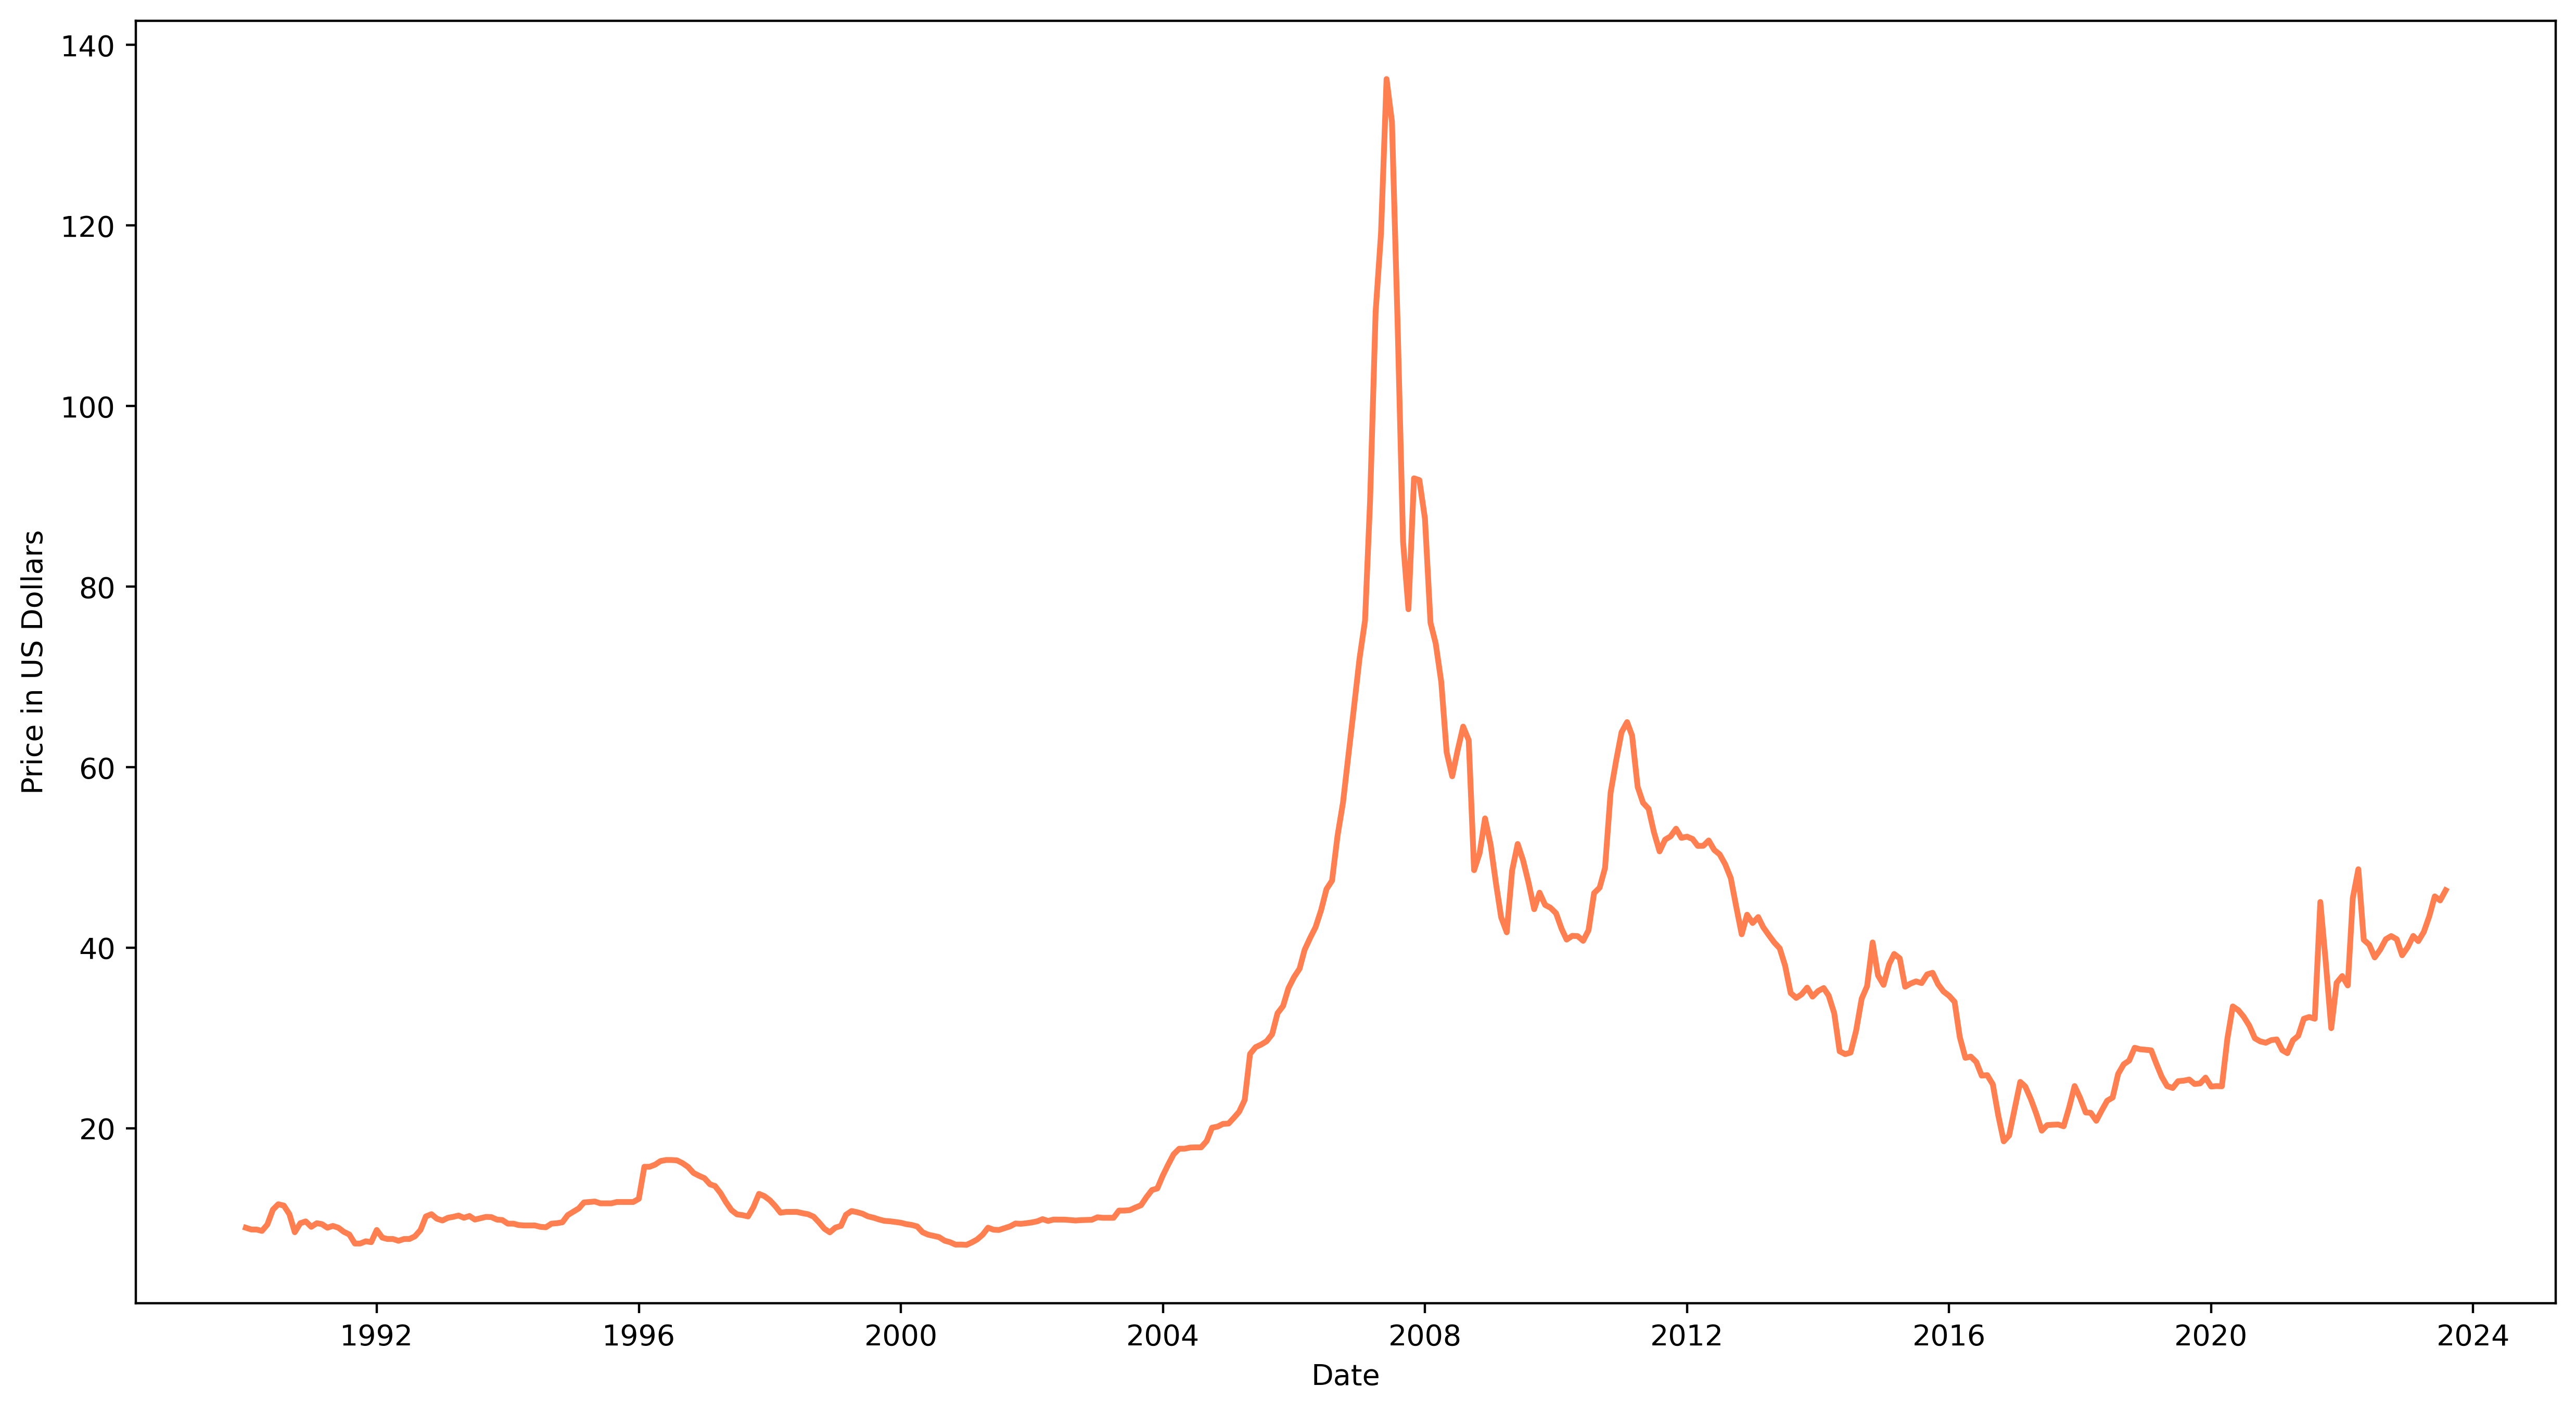

In [4]:
plt.subplots(figsize=(15, 8), dpi = 400)
sns.lineplot(
    x = pd.to_datetime(uranium.DATE),
    y = uranium.PURANUSDM,
    data = uranium,
    color = 'coral',
    linewidth=2,
)
plt.ylabel('Price in US Dollars')
plt.xlabel('Date')
# plt.title('Uranium Price');

In [5]:
ticker_symbol = "DX-Y.NYB"  

ticker = yf.Ticker(ticker_symbol)

start_date = "1990-01-01"
end_date = "2023-08-31"

historical_data = ticker.history(start=start_date, end=end_date, interval="1mo")

usd_index = historical_data['Close'] # USD Index

usd_index.index = pd.to_datetime(usd_index.index)


In [6]:
gld = "GC=F"  

ticker_gld = yf.Ticker(gld)

start_date = "1990-01-01"
end_date = "2023-08-31"
    
historical_data_gold = ticker_gld.history(start=start_date, end=end_date, interval="1mo")

gold = historical_data_gold['Close'] # Gold

gold.index = pd.to_datetime(gold.index)

gold


Date
2000-09-01 00:00:00-04:00     273.600006
2000-11-01 00:00:00-05:00     270.100006
2000-12-01 00:00:00-05:00     272.000000
2001-01-01 00:00:00-05:00     265.600006
2001-02-01 00:00:00-05:00     266.799988
                                ...     
2023-04-01 00:00:00-04:00    1990.099976
2023-05-01 00:00:00-04:00    1963.900024
2023-06-01 00:00:00-04:00    1921.099976
2023-07-01 00:00:00-04:00    1970.500000
2023-08-01 00:00:00-04:00    1938.199951
Name: Close, Length: 236, dtype: float64

In [7]:
slv = "EURUSD=X"  

ticker_slv = yf.Ticker(slv)
    
historical_data_slv = ticker_slv.history(start=start_date, end=end_date, interval="1mo")

silver = historical_data_slv['Close'] # Silver

silver.index = pd.to_datetime(silver.index)

silver



Date
2003-12-01 00:00:00+00:00    1.259002
2004-01-01 00:00:00+00:00    1.245206
2004-02-01 00:00:00+00:00    1.253007
2004-03-01 00:00:00+00:00    1.231300
2004-04-01 00:00:00+01:00    1.198294
                               ...   
2023-04-01 00:00:00+01:00    1.112842
2023-05-01 00:00:00+01:00    1.073307
2023-06-01 00:00:00+01:00    1.086803
2023-07-01 00:00:00+01:00    1.102426
2023-08-01 00:00:00+01:00    1.093255
Name: Close, Length: 237, dtype: float64

In [8]:
spx = "^SPX"  

ticker_spx = yf.Ticker(spx)
    
historical_data_spx = ticker_spx.history(start=start_date, end=end_date, interval="1mo")

sp_500 = historical_data_spx['Close'] # SP 500 Index

sp_500.index = pd.to_datetime(sp_500.index)

sp_500 = pd.DataFrame(sp_500)

sp_500 = sp_500.rename(columns={'Close': 'sp_500'})




In [9]:
df = (
    uranium.merge(fed_rate, on = "DATE")
    .merge(brent, on = "DATE")
    .merge(coal, on = "DATE")
    .merge(cpi_cum, on = "DATE")
    .merge(usd_index, on = usd_index.index)
    .merge(electricity, on = 'DATE')
)

col_names = {
    'DATE': 'date',
    'PURANUSDM': 'uranium',
    'FEDFUNDS': 'fed_rate',
    'POILBREUSDM': 'brent',
    'PCOALAUUSDM': 'coal',
    'CPIAUCSL': 'cpi',
    'Close': 'usd_index',
    'APU000072610': 'electricity'
}

df = df.rename(columns=col_names)

df['date'] = pd.to_datetime(df['date'])

del df['key_0']

df['electricity'] = pd.to_numeric(df['electricity'], errors='coerce')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404 entries, 0 to 403
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         404 non-null    datetime64[ns]
 1   uranium      404 non-null    float64       
 2   fed_rate     404 non-null    float64       
 3   brent        404 non-null    float64       
 4   coal         404 non-null    float64       
 5   cpi          404 non-null    float64       
 6   usd_index    404 non-null    float64       
 7   electricity  404 non-null    float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 25.4 KB


In [10]:
df = df.merge(sp_500, on = sp_500.index)

del df['key_0']

interval columns not set, guessing: ['uranium', 'fed_rate', 'brent', 'coal', 'cpi', 'usd_index', 'electricity', 'sp_500']


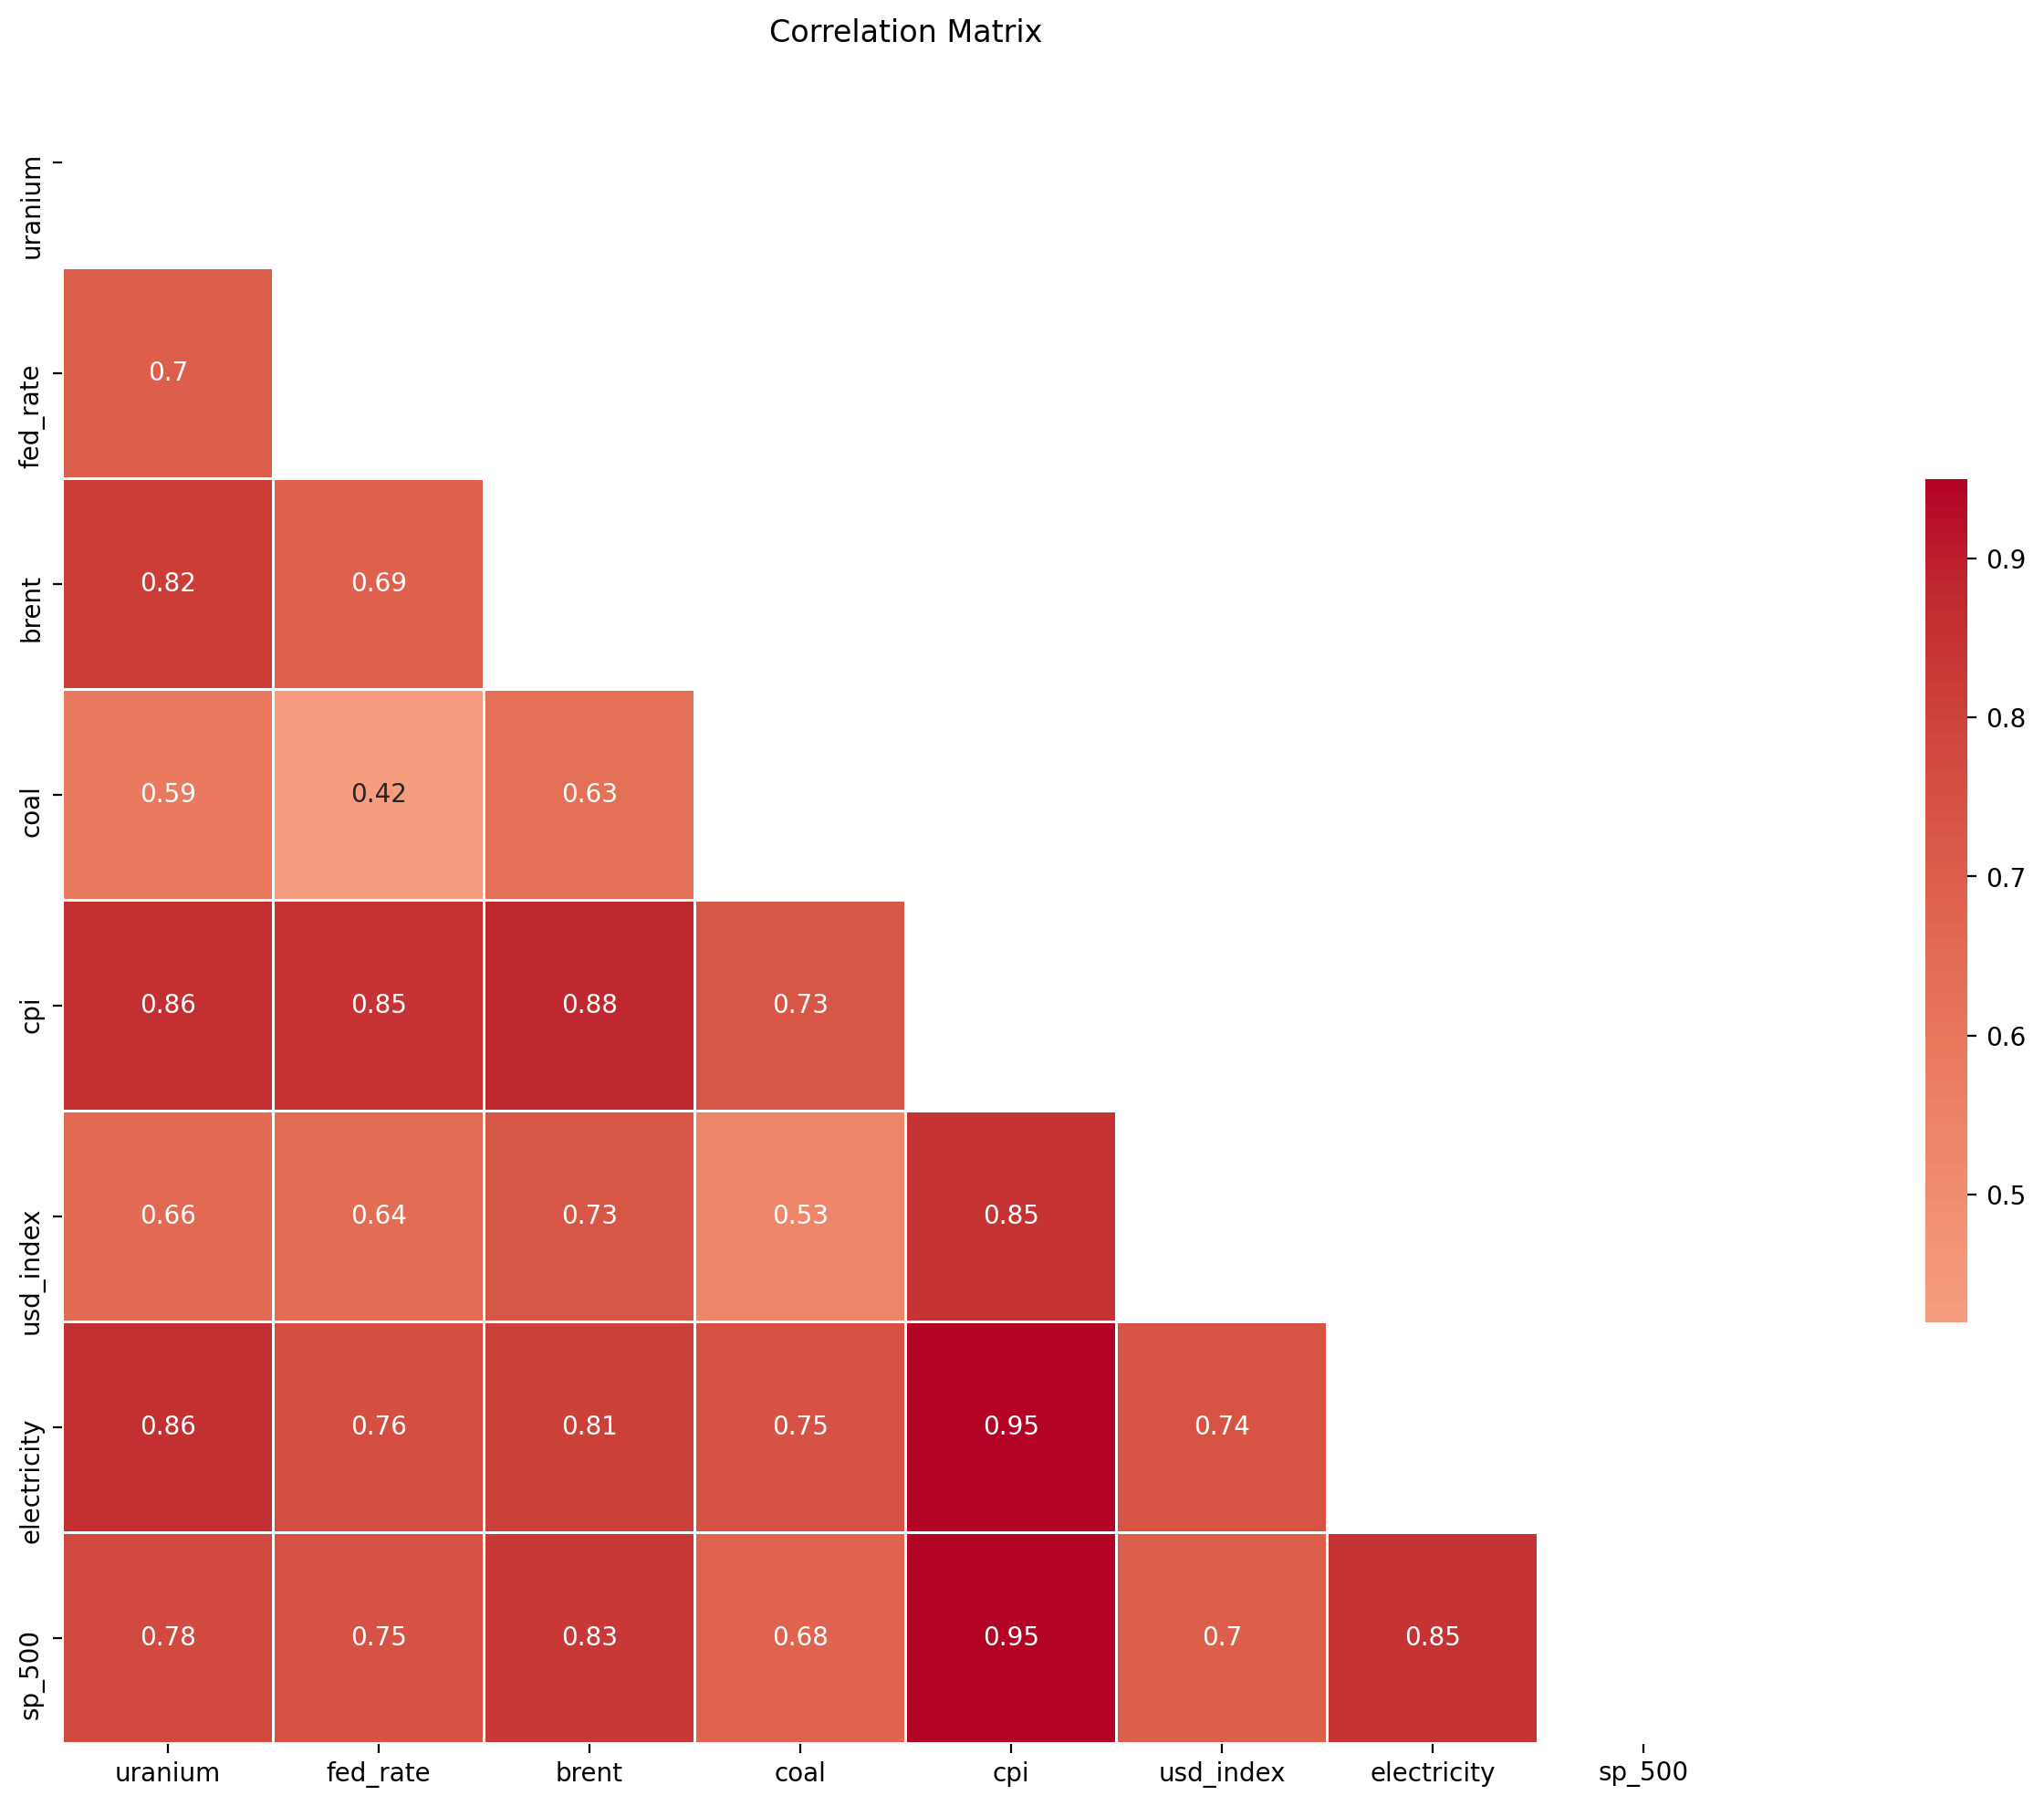

In [11]:
corr_matrix = df.drop(['date'], axis =1).copy().phik_matrix()
corr_matrix.round(2)

mask = np.triu(np.ones_like(corr_matrix.round(2), dtype=bool))
f, ax = plt.subplots(figsize=(25, 12), dpi = 200)

sns.heatmap(
    corr_matrix.round(2), 
    center=-0.07, 
    cmap="coolwarm", 
    square=True,
    linewidth=0.5, 
    cbar_kws={"shrink": .5}, 
    annot=True, 
    mask=mask
)
ax.set_title('Correlation Matrix');

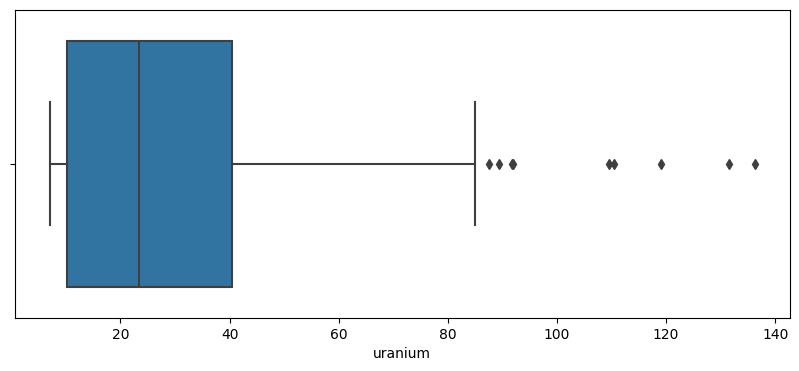

In [12]:
plt.subplots(figsize = (10, 4), dpi = 100)
ax = sns.boxplot(df['uranium']);

In [13]:
df_selection = df.copy()
df_selection['date'] = pd.to_datetime(df_selection['date'])
df_selection = df_selection[df_selection['date'] >= '2009-01-01']

In [14]:
df_selection

,date,uranium,fed_rate,brent,coal,cpi,usd_index,electricity,sp_500
228,2009-01-01,51.444444,0.15,43.174545,85.561735,211.933,86.000000,0.126,825.880005
229,2009-02-01,47.000000,0.22,42.910500,80.822679,212.705,88.010002,0.126,735.090027
230,2009-03-01,43.375000,0.18,46.582727,65.452110,212.495,85.430000,0.126,797.869995
231,2009-04-01,41.718750,0.15,50.519091,66.270536,212.709,84.610001,0.125,872.809998
232,2009-05-01,48.555556,0.18,57.501429,67.015038,213.022,80.430000,0.126,919.140015
...,...,...,...,...,...,...,...,...,...
399,2023-04-01,41.762017,4.83,83.536000,200.676190,302.918,101.669998,0.165,4169.479980
400,2023-05-01,43.462666,5.06,75.747391,179.262321,303.294,104.320000,0.165,4179.830078
401,2023-06-01,45.700483,5.08,74.975000,138.631656,303.841,102.910004,0.170,4450.379883
402,2023-07-01,45.247534,5.12,80.109048,141.029592,304.348,101.860001,0.169,4588.959961


In [15]:
var_selection = (
    sm.OLS(
        df_selection['uranium'],
        df_selection.drop(['uranium', 'date'], axis=1)
    )
)
var_results = var_selection.fit()
var_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                uranium   R-squared (uncentered):                   0.968
Model:                            OLS   Adj. R-squared (uncentered):              0.966
Method:                 Least Squares   F-statistic:                              719.7
Date:                Thu, 23 Nov 2023   Prob (F-statistic):                   3.08e-122
Time:                        21:01:05   Log-Likelihood:                         -588.86
No. Observations:                 176   AIC:                                      1192.
Df Residuals:                     169   BIC:                                      1214.
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
fed_rate       -1.4528      0.535     -2.714      0.007      -2.509      -0.396
brent          -0.0707      0.042     -1.665      0.098      -0.155       0.013
coal            0.0479      0.009      5.293      0.000       0.030       0.066
cpi             0.5938      0.112      5.296      0.000       0.372       0.815
usd_index      -0.9746      0.153     -6.380      0.000      -1.276      -0.673
electricity    56.1483    133.817      0.420      0.675    -208.021     320.317
sp_500         -0.0118      0.001     -8.210      0.000      -0.015      -0.009
==============================================================================
Omnibus:                        0.664   Durbin-Watson:                   0.251
Prob(Omnibus):                  0.717   Jarque-Bera (JB):                0.713
Skew:                           0.144   Prob(JB):                        0.700
Kurtosis:                       2.883   Cond. No.                     6.68e+05
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 6.68e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Modeling

### OLS


In [16]:
y = df_selection.uranium.copy()
X = df_selection.drop(
    ['uranium', 'date','brent', 'electricity', 'fed_rate'],
    axis = 1
).copy()

In [17]:
model_ols = sm.OLS(y, X)
results_ols= model_ols.fit()

results_ols.summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                uranium   R-squared (uncentered):                   0.966
Model:                            OLS   Adj. R-squared (uncentered):              0.965
Method:                 Least Squares   F-statistic:                              1216.
Date:                Thu, 23 Nov 2023   Prob (F-statistic):                   6.40e-125
Time:                        21:01:05   Log-Likelihood:                         -593.35
No. Observations:                 176   AIC:                                      1195.
Df Residuals:                     172   BIC:                                      1207.
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
coal           0.0374      0.008      4.842      0.000       0.022       0.053
cpi            0.5308      0.037     14.235      0.000       0.457       0.604
usd_index     -0.7904      0.095     -8.313      0.000      -0.978      -0.603
sp_500        -0.0113      0.001    -16.773      0.000      -0.013      -0.010
==============================================================================
Omnibus:                        1.595   Durbin-Watson:                   0.208
Prob(Omnibus):                  0.451   Jarque-Bera (JB):                1.437
Skew:                           0.091   Prob(JB):                        0.488
Kurtosis:                       2.596   Cond. No.                         501.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [18]:
# preds
fitted_values = results_ols.fittedvalues


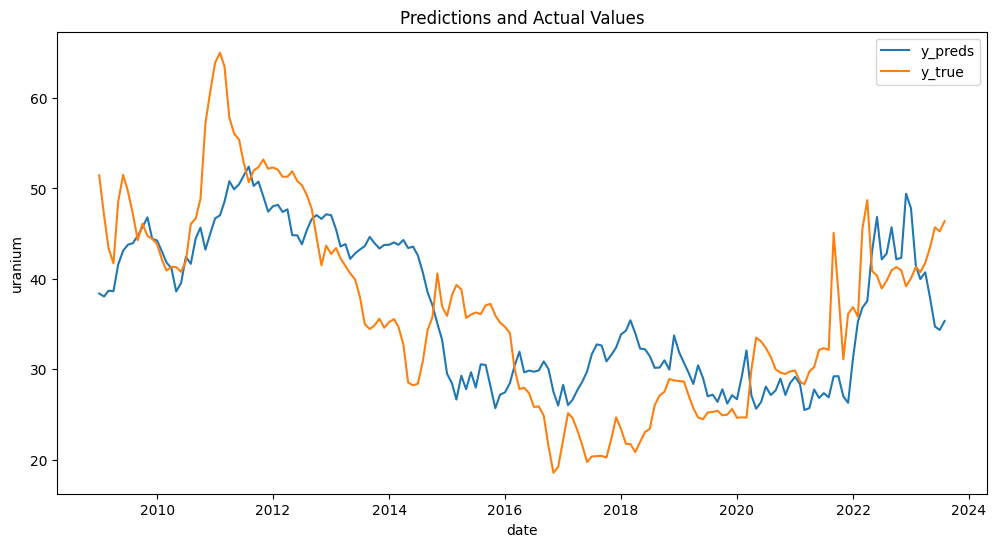

In [19]:
plt.subplots(figsize=(12, 6), dpi =100)

# y-preds
sns.lineplot(
    y=fitted_values, 
    x=df_selection.date,
    label = "y_preds"
)
# y-true
sns.lineplot(
    y=df_selection['uranium'], 
    x=df_selection.date,
    label = 'y_true'
)
plt.title('Predictions and Actual Values');

In [20]:
# MSE and RMSE
print(mean_squared_error(y, fitted_values))
print("RMSE:", mean_squared_error(y, fitted_values) ** 0.5)
print('MAPE:', mean_absolute_percentage_error(y, fitted_values))

49.63860808988013
RMSE: 7.04546720167514
MAPE: 0.17297476236662257


In [21]:
np.random.seed(42)

X_new = pd.DataFrame(
    {
        "coal": np.random.uniform(120, 160, 12),
        'cpi': np.linspace(307, 315, 12),
        'usd_index': np.random.uniform(95, 110, 12),
        'sp_500': np.linspace(4500, 4900, 12)
    }
)


X_new

,coal,cpi,usd_index,sp_500
0,134.981605,307.000000,107.486640,4500.000000
1,158.028572,307.727273,98.185087,4536.363636
2,149.279758,308.454545,97.727375,4572.727273
3,143.946339,309.181818,97.751068,4609.090909
4,126.240746,309.909091,99.563634,4645.454545
5,126.239781,310.636364,102.871346,4681.818182
6,122.323344,311.363636,101.479175,4718.181818
7,154.647046,312.090909,99.368437,4754.545455
8,144.044600,312.818182,104.177793,4790.909091
9,148.322903,313.545455,97.092408,4827.272727


In [22]:
y_preds_12 = results_ols.predict(X_new)

In [23]:
y_preds_12

0     32.091913
1     40.280994
2     40.289334
3     40.045060
4     37.923592
5     35.283303
6     36.211184
7     39.064015
8     34.839860
9     40.574502
10    37.709130
11    38.225252
dtype: float64

In [24]:
new_y = pd.concat([df_selection['uranium'], y_preds_12], ignore_index=True)

new_y

0      51.444444
1      47.000000
2      43.375000
3      41.718750
4      48.555556
         ...    
183    39.064015
184    34.839860
185    40.574502
186    37.709130
187    38.225252
Length: 188, dtype: float64

In [25]:
prediction_intervals = pd.DataFrame(results_ols.get_prediction(X_new).conf_int())
prediction_intervals.index= range(176,188)

In [26]:
plot_df = pd.DataFrame(
    {
    'date': pd.date_range(start='2009-01-01', end='2024-08-01', freq='MS'),
    'price': new_y
}
)

plot_df


,date,price
0,2009-01-01,51.444444
1,2009-02-01,47.000000
2,2009-03-01,43.375000
3,2009-04-01,41.718750
4,2009-05-01,48.555556
...,...,...
183,2024-04-01,39.064015
184,2024-05-01,34.839860
185,2024-06-01,40.574502
186,2024-07-01,37.709130


In [27]:
forecast_date = plot_df.loc[176:187]

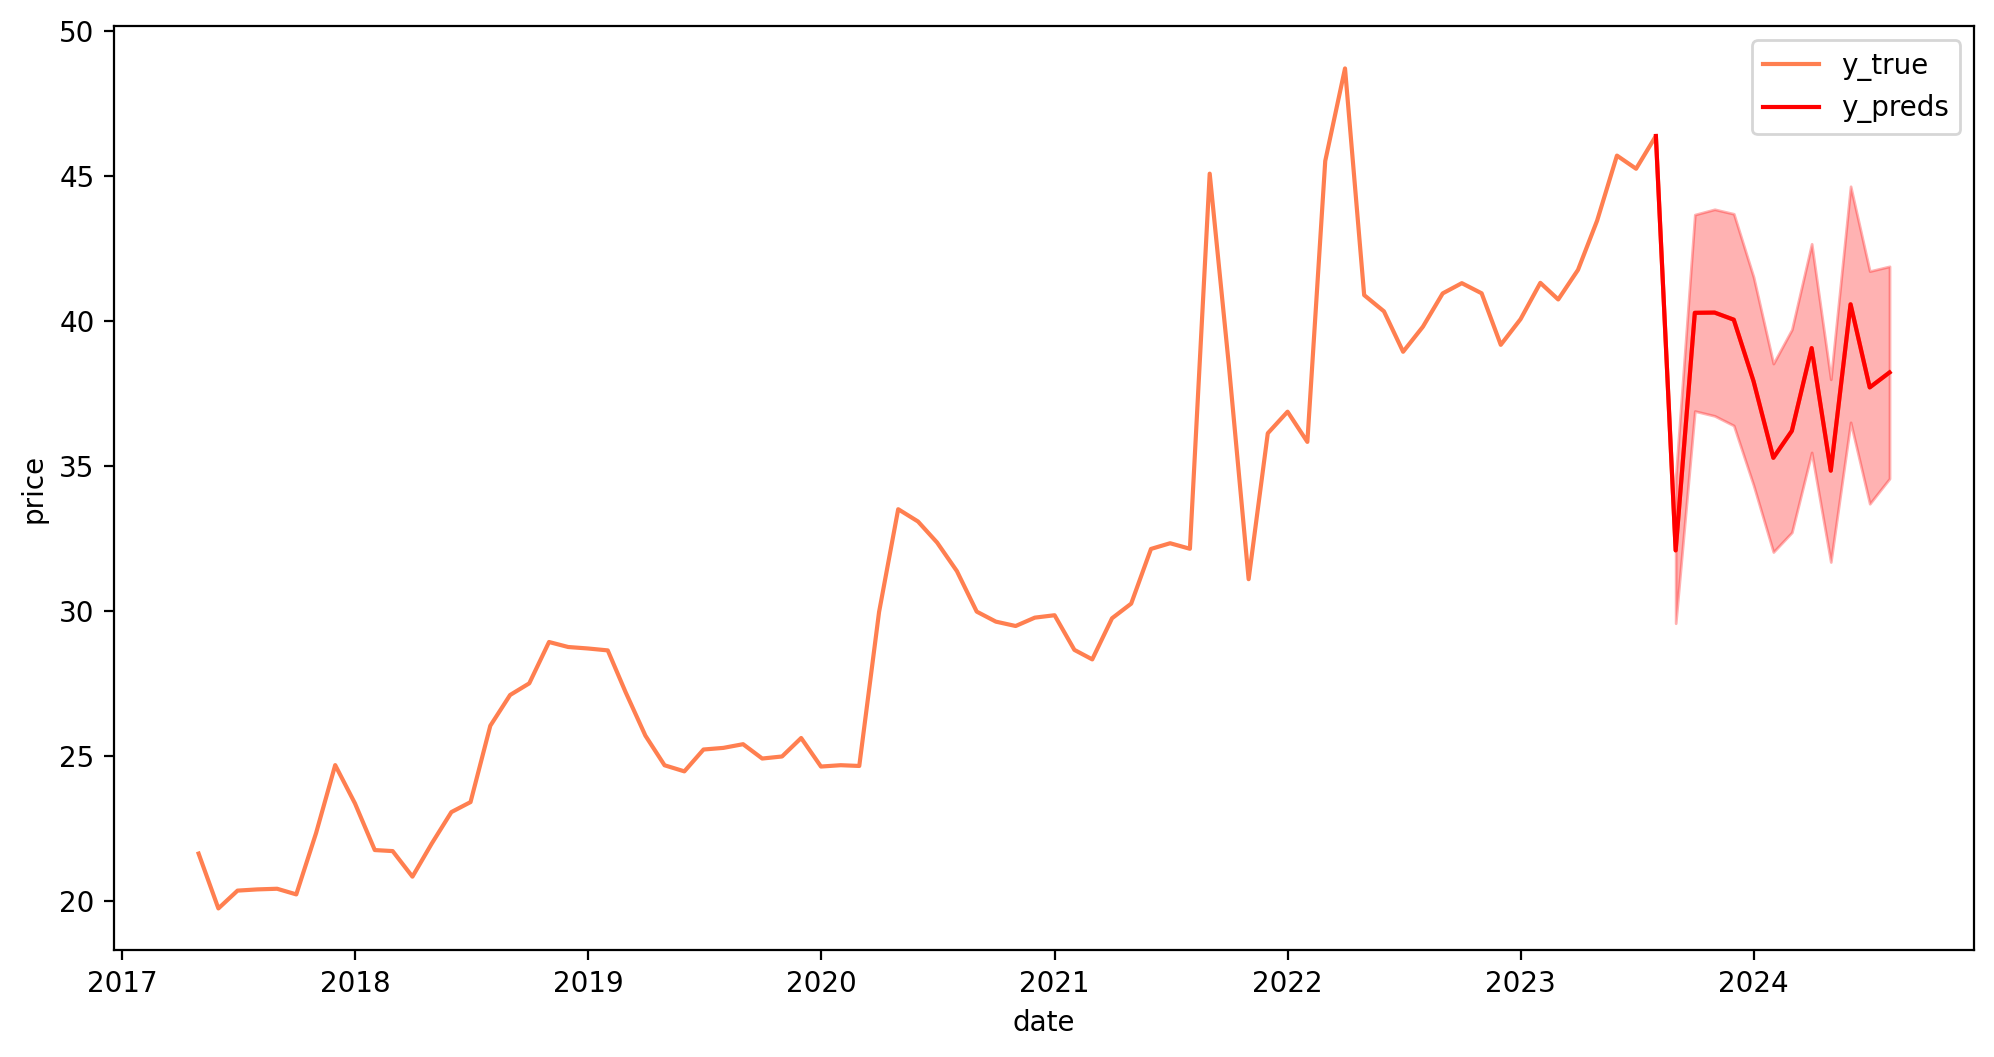

In [28]:
plt.subplots(figsize=(12,6), dpi = 200)
sns.lineplot(data = plot_df[100:], x='date', y='price', color = 'coral', label = 'y_true')
sns.lineplot(data=plot_df.loc[175:187], x='date', y='price',color='red', label = 'y_preds')
plt.fill_between(
    forecast_date.date, 
    prediction_intervals[0], 
    prediction_intervals[1], 
    alpha=0.3, 
    color = 'red',
    label='95% Confidence Interval'
);

In [29]:
results_ols.params

coal         0.037445
cpi          0.530842
usd_index   -0.790399
sp_500      -0.011327
dtype: float64

### Linear Regression

In [30]:
X_with_constant = sm.add_constant(X.copy())
X_new_constant = sm.add_constant(X_new.copy())

model_ols_constant = sm.OLS(y, X_with_constant)
results_constant = model_ols_constant.fit()

results_constant.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                uranium   R-squared:                       0.564
Model:                            OLS   Adj. R-squared:                  0.553
Method:                 Least Squares   F-statistic:                     55.22
Date:                Thu, 23 Nov 2023   Prob (F-statistic):           7.92e-30
Time:                        21:01:05   Log-Likelihood:                -590.66
No. Observations:                 176   AIC:                             1191.
Df Residuals:                     171   BIC:                             1207.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         41.1517     17.863      2.304      0.022       5.892      76.412
coal           0.0508      0.010      5.296      0.000       0.032       0.070
cpi            0.3186      0.099      3.210      0.002       0.123       0.514
usd_index     -0.7842      0.094     -8.347      0.000      -0.970      -0.599
sp_500        -0.0076      0.002     -4.283      0.000      -0.011      -0.004
==============================================================================
Omnibus:                        1.238   Durbin-Watson:                   0.210
Prob(Omnibus):                  0.538   Jarque-Bera (JB):                1.224
Skew:                           0.096   Prob(JB):                        0.542
Kurtosis:                       2.640   Cond. No.                     8.88e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.88e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [31]:
preds_constant = results_constant.predict(X_with_constant)
preds_constant

228    39.328394
229    38.443798
230    39.144148
231    39.330260
232    42.395317
         ...    
399    36.591217
400    33.466322
401    30.635401
402    30.694259
403    31.138666
Length: 176, dtype: float64

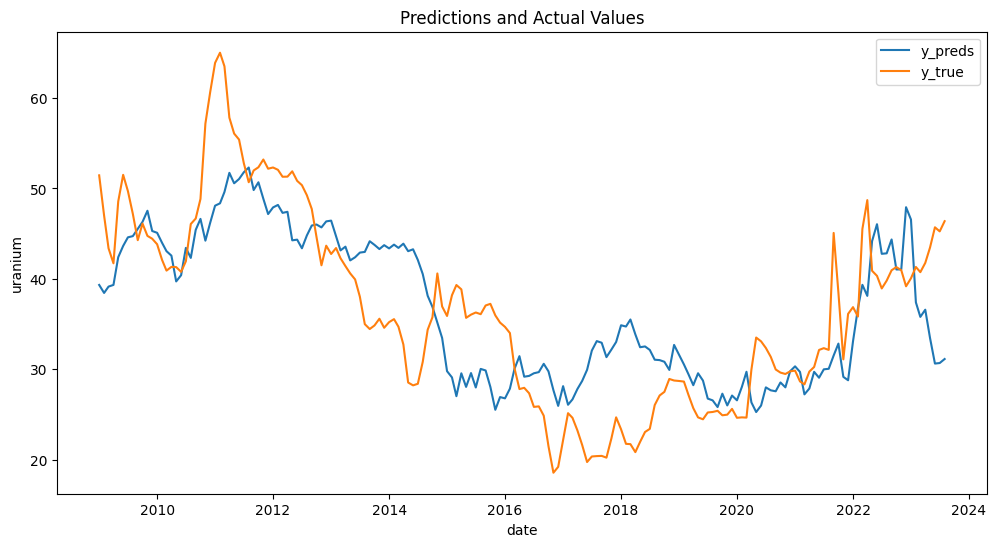

In [32]:
plt.subplots(figsize=(12, 6), dpi =100)

# y-preds
sns.lineplot(
    y=preds_constant, 
    x=df_selection.date,
    label = "y_preds"
)
# y-true
sns.lineplot(
    y=df_selection['uranium'], 
    x=df_selection.date,
    label = 'y_true'
)
plt.title('Predictions and Actual Values');

In [33]:
print(mean_squared_error(y, preds_constant))
print("RMSE:", mean_squared_error(y, preds_constant) ** 0.5)
print('MAPE:', mean_absolute_percentage_error(y, preds_constant))

48.1443434205162
RMSE: 6.938612499665636
MAPE: 0.1685189993829194


In [34]:
lm_preds_12 = pd.Series(results_constant.predict(X_new_constant))
lm_new_y = pd.concat([df_selection['uranium'], lm_preds_12], ignore_index=True)

In [35]:
prediction_intervals_const = pd.DataFrame(
    results_constant.get_prediction(X_new_constant).conf_int()
)
prediction_intervals_const.index= range(176,188)

In [36]:
plot_df_2 = pd.DataFrame(
    {
    'date': pd.date_range(start='2009-01-01', end='2024-08-01', freq='MS'),
    'price': lm_new_y
}
)

plot_df_2

,date,price
0,2009-01-01,51.444444
1,2009-02-01,47.000000
2,2009-03-01,43.375000
3,2009-04-01,41.718750
4,2009-05-01,48.555556
...,...,...
183,2024-04-01,34.554598
184,2024-05-01,30.201068
185,2024-06-01,35.931387
186,2024-07-01,32.694876


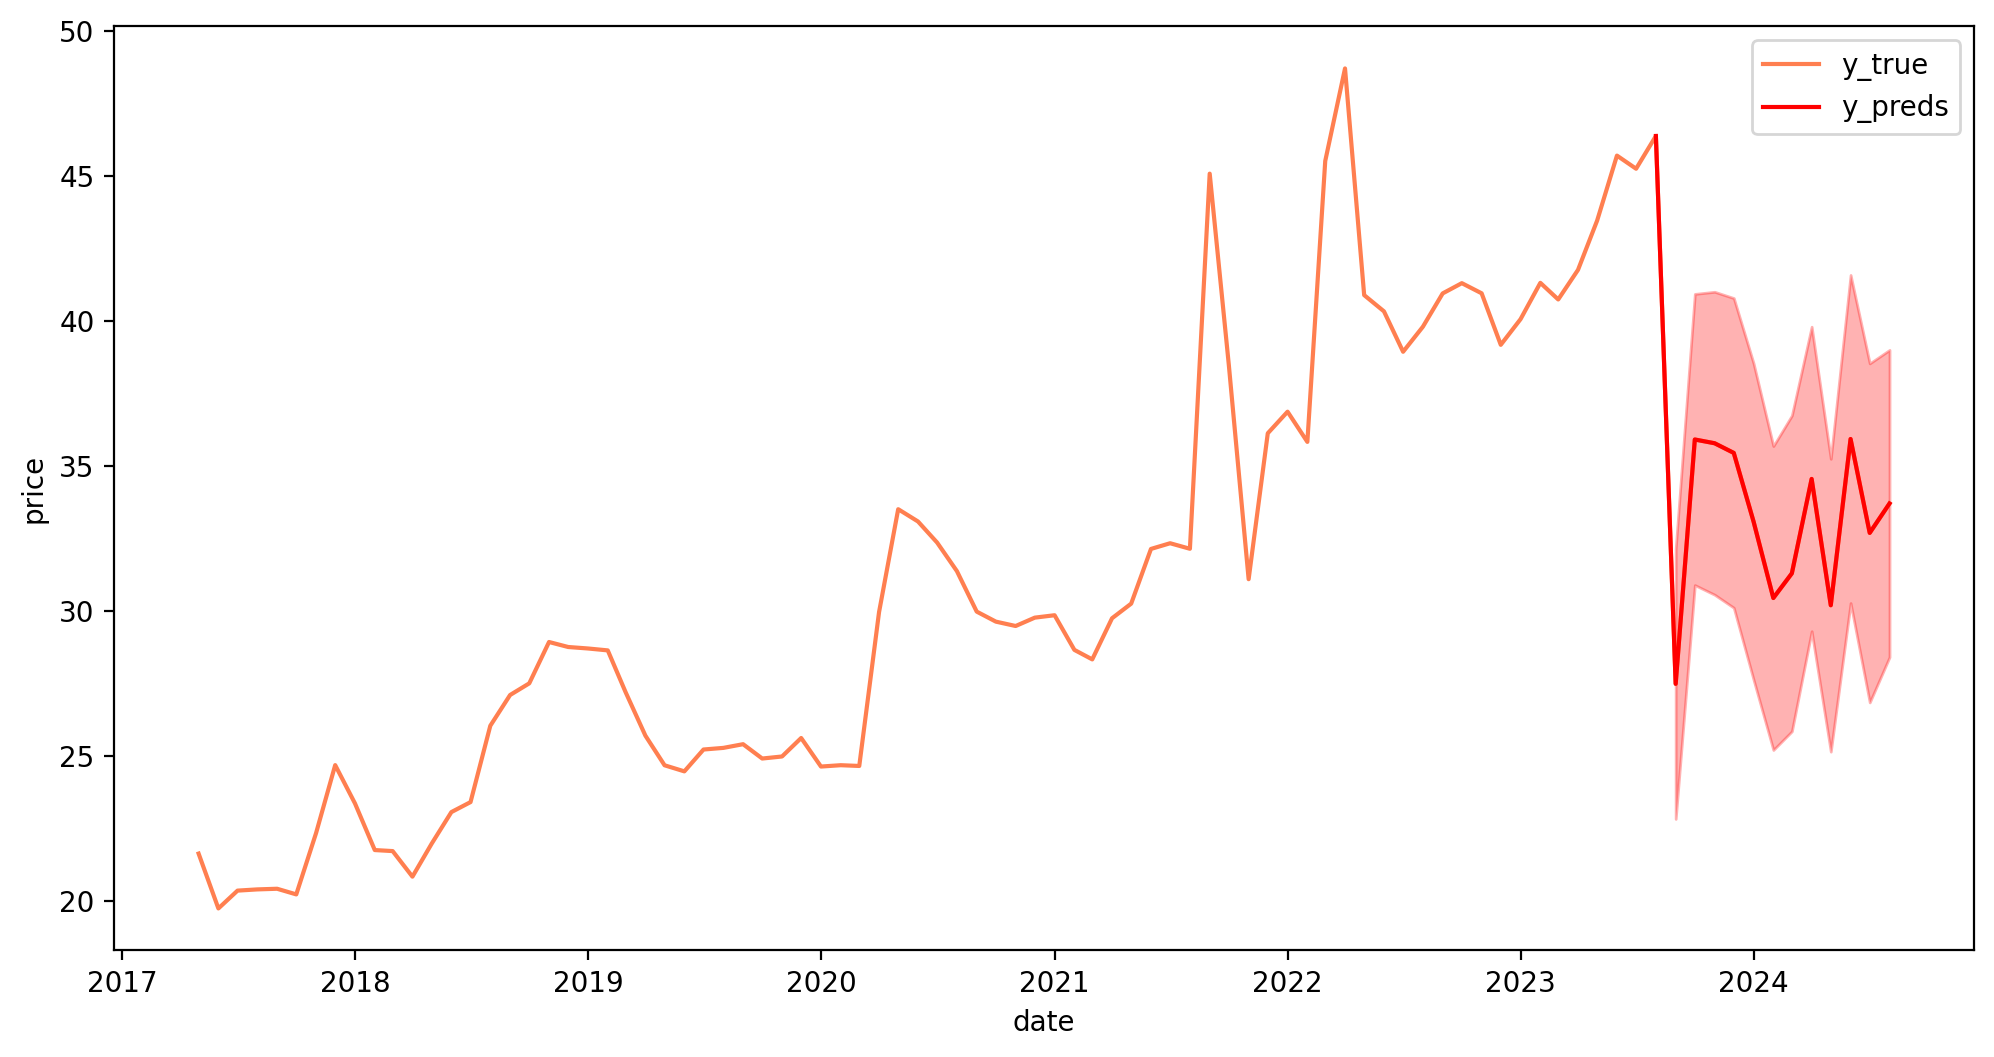

In [37]:
plt.subplots(figsize=(12,6), dpi = 200)
sns.lineplot(data = plot_df_2[100:], x='date', y='price', color = 'coral', label = 'y_true')
sns.lineplot(data=plot_df_2.loc[175:187], x='date', y='price',color='red', label = 'y_preds')
plt.fill_between(
    forecast_date.date, 
    prediction_intervals_const[0], 
    prediction_intervals_const[1], 
    alpha=0.3, 
    color = 'red',
    label='95% Confidence Interval'
);

In [38]:
def diebold_mariano_test(actual, forecast1, forecast2, h=1):
    """
    Perform Diebold-Mariano test for the equality of two forecast accuracy.

    Parameters:
    actual (array-like): Actual values of the time series.
    forecast1 (array-like): Forecast values from the first model.
    forecast2 (array-like): Forecast values from the second model.
    h (int): Forecast horizon. Default is 1.

    Returns:
    dm_stat (float): Diebold-Mariano test statistic.
    p_value (float): p-value associated with the test statistic.
    """
    e1 = actual - forecast1
    e2 = actual - forecast2

    mse1 = np.mean(e1**2)
    mse2 = np.mean(e2**2)

    dm_stat = (mse1 - mse2) / np.sqrt((mse1**2 + mse2**2) / (len(actual) - h))

    p_value = 2 * (1 - t.cdf(np.abs(dm_stat), df=len(actual) - h))

    return dm_stat, p_value

In [39]:
dm_stat, p_value = diebold_mariano_test(y, fitted_values, preds_constant)
print("Diebold-Mariano Test Statistic:", dm_stat)
print("P-value:", p_value)

alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis. There is a significant difference in forecast accuracy.")
else:
    print("Fail to reject the null hypothesis. There is no significant difference in forecast accuracy.")

Diebold-Mariano Test Statistic: 0.28585625871309034
P-value: 0.7753263017858774
Fail to reject the null hypothesis. There is no significant difference in forecast accuracy.
